## This script contains the following:

##### 1. Importing your libraries and data
##### 2. Subsetting, wrangling, and cleaning time-series data
##### 3. Time series analysis: decomposition
##### 4. Testing for stationarity
##### 5. Stationarizing the Federal Reserve Economic Data

# 1. Importing libraries

In [1]:
# 1. Install the Quandl library and register for a Quandl account as described in the Exercise. 
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'ryEq-duxXzPEWpUCL4aX'

In [4]:
# 2. Import IMF Cross Country Macroeconomic Statistics (Zimbabwe)

data_ZIM=quandl.get('ODA/ZWE_NGDPRPPPPC')

In [5]:
data_ZIM.head()

,Value
Date,
1998-12-31,3285.33
1999-12-31,3257.71
2000-12-31,3128.15
2001-12-31,3121.96
2002-12-31,2889.12


In [6]:
data_ZIM.shape

(27, 1)

In [7]:
data_ZIM.columns

Index(['Value'], dtype='object')

In [9]:
type(data_ZIM)

pandas.core.frame.DataFrame

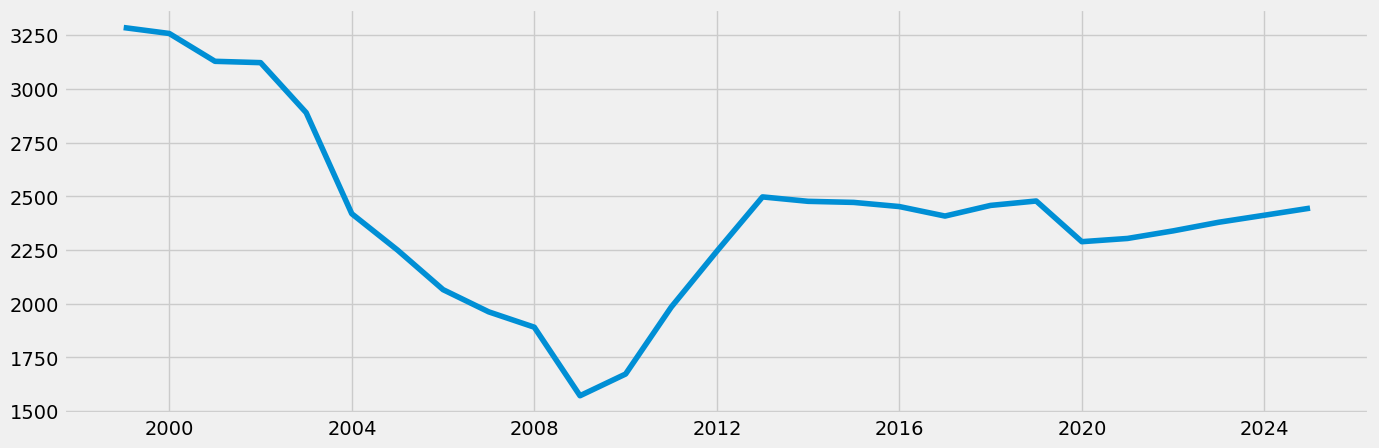

In [11]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data_ZIM)

# Subsetting, wrangling, and cleaning time-series data

In [12]:
# Reset index so that you can use the "Date" column as a filter

data_2=data_ZIM.reset_index()

In [13]:
data_2.head()

,Date,Value
0,1998-12-31,3285.33
1,1999-12-31,3257.71
2,2000-12-31,3128.15
3,2001-12-31,3121.96
4,2002-12-31,2889.12


In [22]:
data_sub=data_2.loc[(data_2['Date']>='2014-01-01')&(data_2['Date']<'2020-12-31')]

In [23]:
data_sub.shape

(6, 2)

In [24]:
data_sub.head()

,Date,Value
16,2014-12-31,2471.36
17,2015-12-31,2452.06
18,2016-12-31,2407.85
19,2017-12-31,2457.42
20,2018-12-31,2477.92


In [25]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
2014-12-31,2471.36
2015-12-31,2452.06
2016-12-31,2407.85
2017-12-31,2457.42
2018-12-31,2477.92


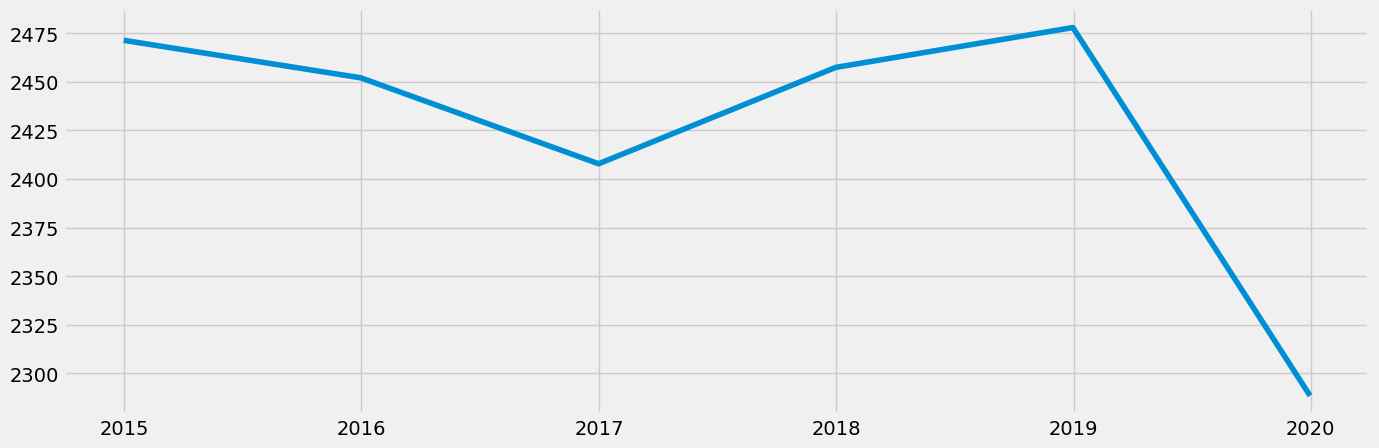

In [26]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [28]:
# Check for missing values
data_sub.isnull().sum()

Value    0
dtype: int64

In [29]:
# Check for duplicates
dups=data_sub.duplicated()
dups.sum()
# No dups

0

# 3. Decomposition

In [46]:
# Decompose the time series using a multiplicative model
decomposition=sm.tsa.seasonal_decompose(data_sub, model='additive')

In [47]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

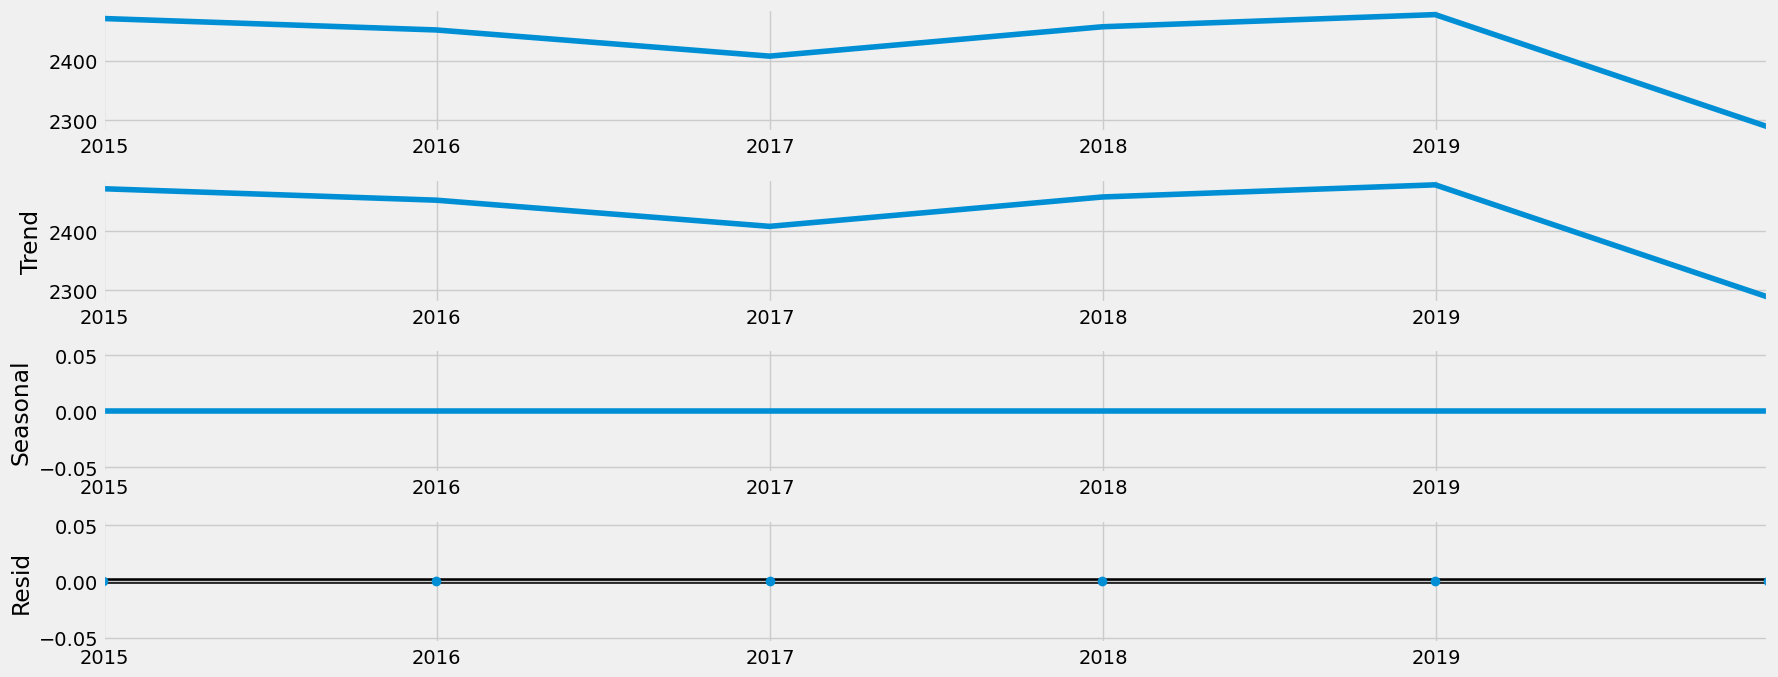

In [48]:
# Plot the separate components

decomposition.plot()
plt.show()

no movement in seasonality or residual 

# 4. Testing for Stationarity

In [49]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                -2.241866
p-value                        0.191403
Number of Lags Used            1.000000
Number of Observations Used    4.000000
Critical Value (1%)           -7.355441
Critical Value (5%)           -4.474365
Critical Value (10%)          -3.126933
dtype: float64


Test statistic larger than ciritical value. Therefore, can't reject null hypotheses. And data is non-stationary. 

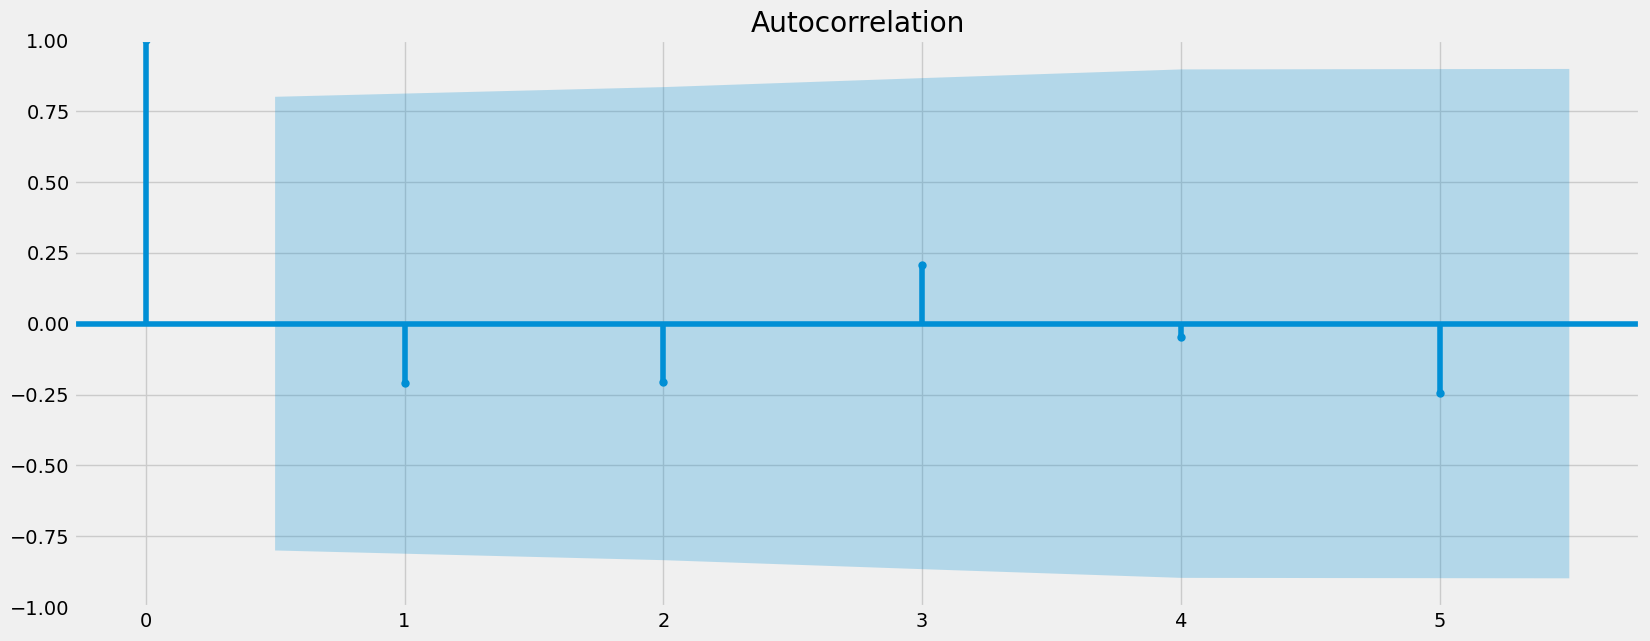

In [50]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

# 5. Stationarizing

In [58]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [59]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [60]:
data_diff.head()

,Value
datetime,
2015-12-31,-19.30
2016-12-31,-44.21
2017-12-31,49.57
2018-12-31,20.50
2019-12-31,-189.38


In [61]:
data_diff.columns

Index(['Value'], dtype='object')

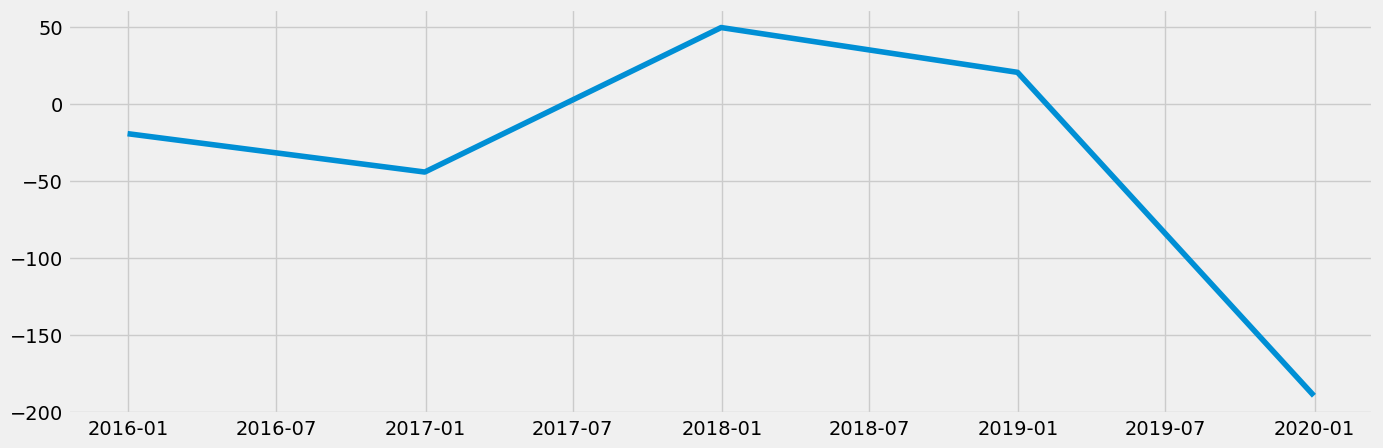

In [62]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [63]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -1.017086
p-value                        0.746982
Number of Lags Used            0.000000
Number of Observations Used    4.000000
Critical Value (1%)           -7.355441
Critical Value (5%)           -4.474365
Critical Value (10%)          -3.126933
dtype: float64


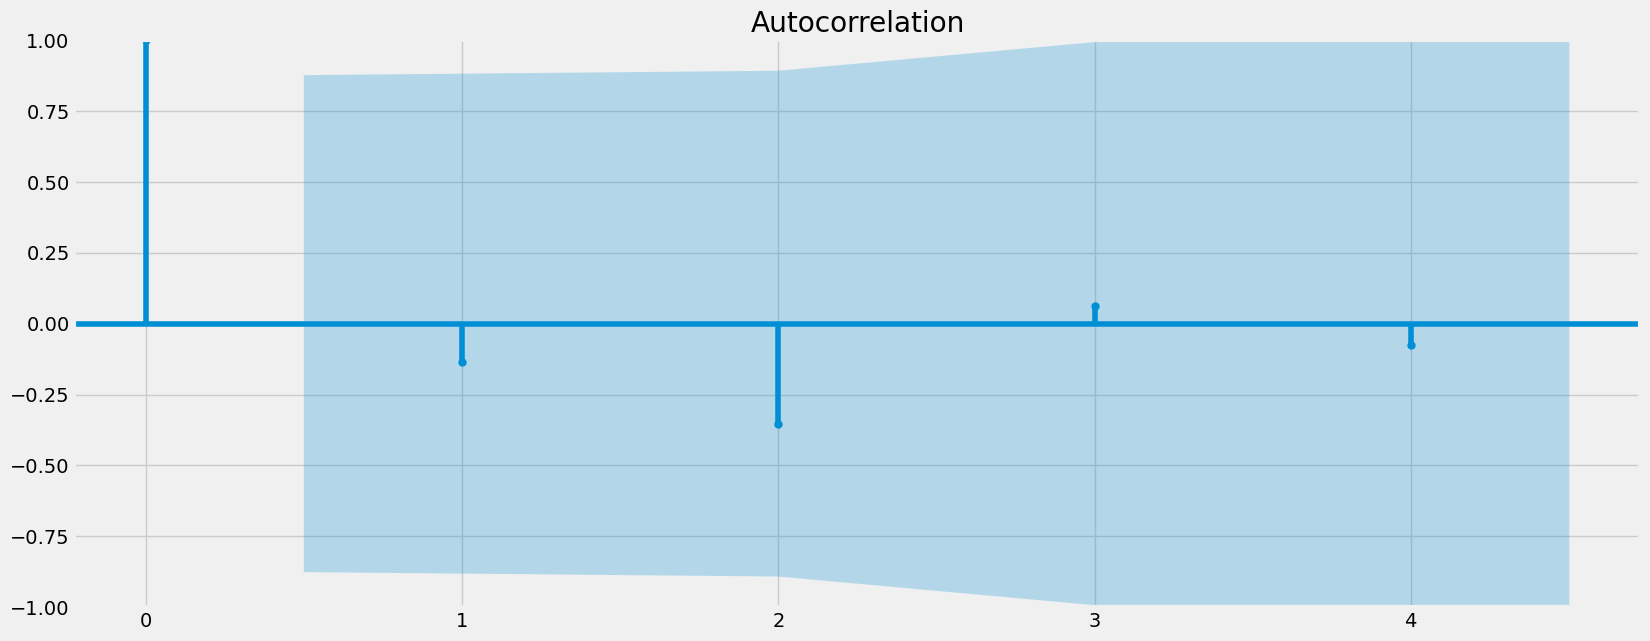

In [64]:
plot_acf(data_diff)
plt.show()

Still not stationary

# Stationarizing pt. 2

In [65]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [66]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [67]:
data_diff.head()

,Value
datetime,
2015-12-31,-19.30
2016-12-31,-44.21
2017-12-31,49.57
2018-12-31,20.50
2019-12-31,-189.38


In [70]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -1.017086
p-value                        0.746982
Number of Lags Used            0.000000
Number of Observations Used    4.000000
Critical Value (1%)           -7.355441
Critical Value (5%)           -4.474365
Critical Value (10%)          -3.126933
dtype: float64
